In [1]:
# Import libraries
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lokasi file ZIP dataset (gunakan raw string atau double backslash)
zip_path = r"C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset.zip"  # Raw string untuk menghindari masalah backslash
extract_path = r"C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset"  # Lokasi folder untuk mengekstrak dataset

# Memastikan file ZIP tersedia
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"File ZIP '{zip_path}' tidak ditemukan. Periksa kembali lokasi file.")

# Ekstrak file ZIP jika belum diekstrak
if not os.path.exists(extract_path):
    os.makedirs(extract_path)  # Buat folder jika belum ada
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"File berhasil diekstrak ke: {extract_path}")
else:
    print(f"Dataset sudah diekstrak di: {extract_path}")

# Menampilkan daftar file di folder hasil ekstraksi
files = os.listdir(extract_path)
print("File yang tersedia setelah ekstraksi:", files)

# Fungsi untuk memuat dataset
def load_data(file_name):
    file_path = os.path.join(extract_path, file_name)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File '{file_name}' tidak ditemukan di '{extract_path}'.")
    print(f"Memuat file: {file_name}")
    return pd.read_csv(file_path, dtype={'order_id': 'category', 'customer_id': 'category'})

Dataset sudah diekstrak di: C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset
File yang tersedia setelah ekstraksi: ['olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv']


In [2]:
# Load datasets
customers = load_data('olist_customers_dataset.csv')
orders = load_data('olist_orders_dataset.csv')
order_reviews = load_data('olist_order_reviews_dataset.csv')
order_items = load_data('olist_order_items_dataset.csv')
payments = load_data('olist_order_payments_dataset.csv')
products = load_data('olist_products_dataset.csv')
sellers = load_data('olist_sellers_dataset.csv')
product_translation = load_data('product_category_name_translation.csv')
product_translation = pd.read_csv(os.path.join(extract_path, 'product_category_name_translation.csv'))

Memuat file: olist_customers_dataset.csv
Memuat file: olist_orders_dataset.csv
Memuat file: olist_order_reviews_dataset.csv
Memuat file: olist_order_items_dataset.csv
Memuat file: olist_order_payments_dataset.csv
Memuat file: olist_products_dataset.csv
Memuat file: olist_sellers_dataset.csv
Memuat file: product_category_name_translation.csv


In [3]:
# 1) Customers Table: Remove customer_unique_id and duplicates based on customer_id
customers_cleaned = customers.drop_duplicates(subset='customer_id').drop(columns=['customer_unique_id'])
print("Customers table cleaned. No duplicates.")

# 2) Geo-location Table: This table is not used
# Skip loading or processing geolocation data

# 3) Order Items Table: Summarize freight value and item price for each order, remove duplicates
order_items_cleaned = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()
order_items_cleaned = order_items_cleaned.drop_duplicates(subset='order_id')
print("Order items table cleaned. No duplicates.")

# 4) Payments Table: Summarize payment values for each order_id, remove duplicates
payments_cleaned = payments.groupby('order_id').agg({
    'payment_value': 'sum'
}).reset_index()
payments_cleaned = payments_cleaned.drop_duplicates(subset='order_id')
print("Payments table cleaned. No duplicates.")

# 5) Order Reviews Table: Keep the latest review for each order_id
order_reviews_cleaned = order_reviews.drop(columns=['review_comment_title', 'review_comment_message'])
order_reviews_cleaned = order_reviews_cleaned.sort_values('review_creation_date').drop_duplicates(subset='order_id', keep='last')
print("Order reviews table cleaned. No duplicates.")

# 6) Order Table: Remove duplicates based on order_id
orders_cleaned = orders.drop_duplicates(subset='order_id')
print("Orders table cleaned. No duplicates.")

# 7) Products Table: Translate product category names, remove duplicates
products_cleaned = pd.merge(products, product_translation, on='product_category_name', how='left') \
    .drop(columns=['product_category_name']).rename(columns={'product_category_name_english': 'product_category'})
products_cleaned = products_cleaned.drop_duplicates(subset='product_id')
print("Products table cleaned. No duplicates.")

# 8) Sellers Table: Remove duplicates based on seller_id
sellers_cleaned = sellers.drop_duplicates(subset='seller_id')
print("Sellers table cleaned. No duplicates.")

# Merge necessary tables for further EDA or modeling
# Merging orders, customers, order items, payments, and reviews for comprehensive analysis
train_data = orders_cleaned.merge(customers_cleaned, on='customer_id', how='inner')
train_data = train_data.merge(order_items_cleaned, on='order_id', how='inner')
train_data = train_data.merge(payments_cleaned, on='order_id', how='inner')
train_data = train_data.merge(order_reviews_cleaned, on='order_id', how='left')

# Ensure no duplicates in the final merged dataset
train_data = train_data.drop_duplicates()
print("Final dataset cleaned and merged successfully. No duplicates.")

Customers table cleaned. No duplicates.
Order items table cleaned. No duplicates.
Payments table cleaned. No duplicates.
Order reviews table cleaned. No duplicates.
Orders table cleaned. No duplicates.
Products table cleaned. No duplicates.
Sellers table cleaned. No duplicates.


C:\Users\Raffi\AppData\Local\Temp\ipykernel_24736\1575491345.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_items_cleaned = order_items.groupby('order_id').agg({
C:\Users\Raffi\AppData\Local\Temp\ipykernel_24736\1575491345.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payments_cleaned = payments.groupby('order_id').agg({


Final dataset cleaned and merged successfully. No duplicates.


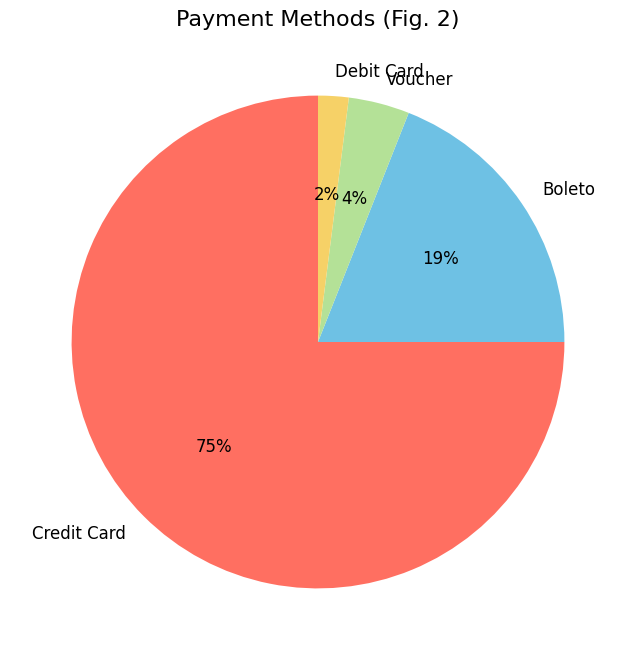

In [4]:
# Fig. 2: Payment methods distribution with percentages

import matplotlib.pyplot as plt

# Define the payment methods and their corresponding percentages
payment_methods = {
    'Credit Card': 75,
    'Boleto': 19,
    'Voucher': 4,
    'Debit Card': 2
}

# Colors for the segments
colors = ['#FF6F61', '#6EC1E4', '#B4E197', '#F6D167']

# Plot Fig. 2
plt.figure(figsize=(8, 8))
plt.pie(
    payment_methods.values(),
    labels=payment_methods.keys(),
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title("Payment Methods (Fig. 2)", fontsize=16)
plt.show()

C:\Users\Raffi\AppData\Local\Temp\ipykernel_24736\3353698549.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_distribution.index, y=state_distribution.values, palette='viridis')


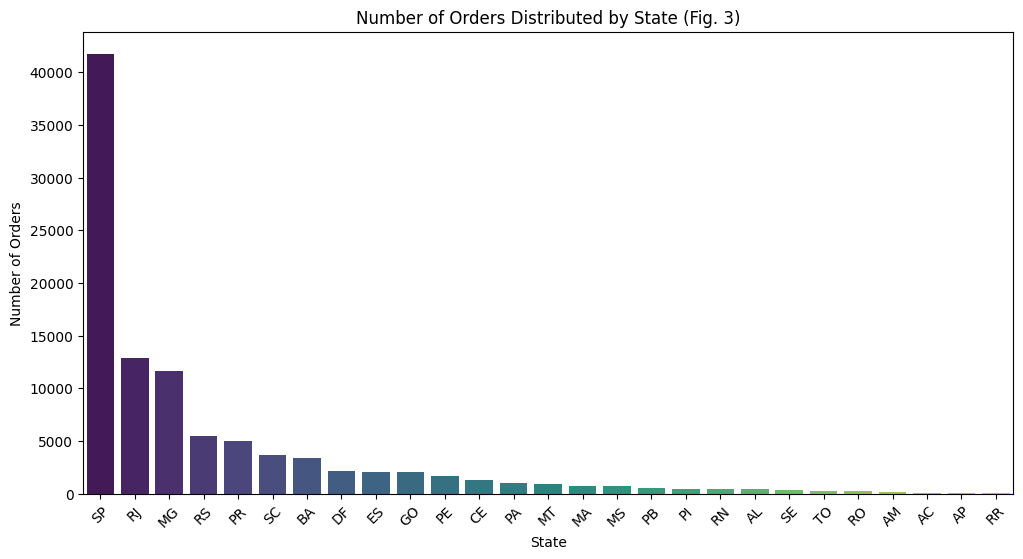

In [5]:
# Fig. 3: Number of orders distributed by state
orders_customers = pd.merge(orders, customers, on='customer_id')
state_distribution = orders_customers['customer_state'].value_counts()

# Plot Fig. 3
plt.figure(figsize=(12, 6))
sns.barplot(x=state_distribution.index, y=state_distribution.values, palette='viridis')
plt.title('Number of Orders Distributed by State (Fig. 3)')
plt.xlabel('State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
# Memastikan dataset utama 'train_data' sudah tersedia dan tidak ada duplikasi
train_data = train_data.drop_duplicates()

# Periksa jumlah total data
total_records = len(train_data)
print(f"Total records in the dataset: {total_records}")

# 1. Split Data: Pisahkan dataset menjadi train dan test dengan rasio 75:25
train_data, test_data = train_test_split(train_data, test_size=0.25, random_state=42)

# Verifikasi ukuran data setelah split
train_size = len(train_data)
test_size = len(test_data)

print(f"Train data size: {train_size} records")
print(f"Test data size: {test_size} records")

# Verifikasi rasio pembagian
train_ratio = train_size / total_records
test_ratio = test_size / total_records

print(f"Train ratio: {train_ratio:.2f}")
print(f"Test ratio: {test_ratio:.2f}")

# Validasi apakah rasio sudah sesuai dengan 75:25
if not (0.74 <= train_ratio <= 0.76):  # Mempertimbangkan sedikit variasi karena pembulatan
    print(f"Warning: Train ratio is {train_ratio:.2f}, expected around 0.75.")
if not (0.24 <= test_ratio <= 0.26):
    print(f"Warning: Test ratio is {test_ratio:.2f}, expected around 0.25.")

Total records in the dataset: 98665
Train data size: 73998 records
Test data size: 24667 records
Train ratio: 0.75
Test ratio: 0.25


C:\Users\Raffi\AppData\Local\Temp\ipykernel_24736\3110751400.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=review_distribution.index, y=review_distribution.values, palette='coolwarm')


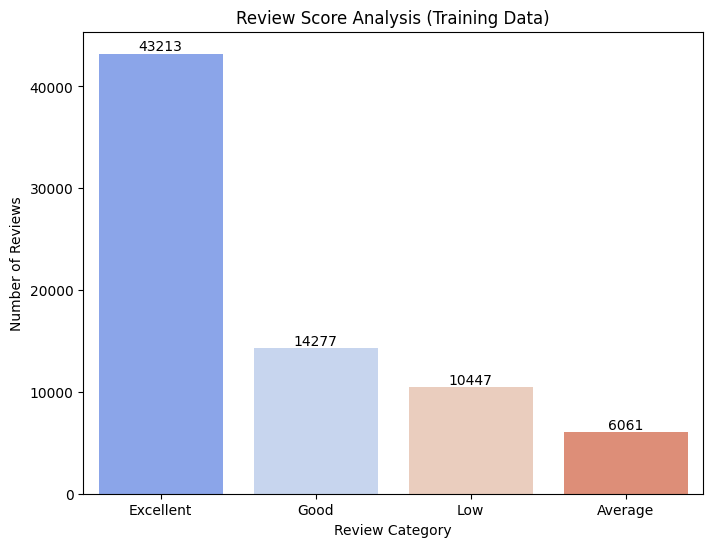

In [7]:
# Fig. 4: Analyzing review scores on training data
# Group review scores into categories
def review_category(score):
    if score < 3:
        return 'Low'
    elif score == 3:
        return 'Average'
    elif score == 4:
        return 'Good'
    else:
        return 'Excellent'

# Apply the review category function to the training data
train_data['review_category'] = train_data['review_score'].apply(review_category)
review_distribution = train_data['review_category'].value_counts()

# Plot Fig. 4
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=review_distribution.index, y=review_distribution.values, palette='coolwarm')
plt.title('Review Score Analysis (Training Data)')
plt.xlabel('Review Category')
plt.ylabel('Number of Reviews')

# Annotate each bar with the corresponding value
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')

plt.show()


In [8]:
# # Import additional necessary libraries
# from datetime import datetime

# # 1) Process Duration Features
# # Convert dates to datetime format (if not already done)
# train_data['order_purchase_timestamp'] = pd.to_datetime(train_data['order_purchase_timestamp'])
# train_data['order_delivered_customer_date'] = pd.to_datetime(train_data['order_delivered_customer_date'])

# # 2) Calculate Delivery Performance
# # Delivery performance is the difference between actual delivery date and order purchase date
# train_data['delivery_performance'] = (train_data['order_delivered_customer_date'] - train_data['order_purchase_timestamp']).dt.days

# # Display the first few rows to verify the new variable
# print(train_data[['order_purchase_timestamp', 'order_delivered_customer_date', 'delivery_performance']].head())


In [9]:

# 1. Gabungkan order_items dengan sellers berdasarkan seller_id
order_items_with_sellers = order_items.merge(sellers[['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']], on='seller_id', how='left')

# 2. Tampilkan beberapa baris pertama dari hasil gabungan
print(order_items_with_sellers.head())


                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  seller_zip_code_prefix  \
0  2017-09-19 09:45:35   58.90          13.29                   27277   
1  2017-05-03 11:05:13  239.90          19.93                    3471   
2  2018-01-18 14:

In [10]:

# Load all the datasets
order_items = pd.read_csv(r'C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset\olist_order_items_dataset.csv')
sellers = pd.read_csv(r'C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset\olist_sellers_dataset.csv')
order_reviews = pd.read_csv(r'C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset\olist_order_reviews_dataset.csv')
order_payments = pd.read_csv(r'C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset\olist_order_payments_dataset.csv')
orders = pd.read_csv(r'C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset\olist_orders_dataset.csv')
customers = pd.read_csv(r'C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset\olist_customers_dataset.csv')
products = pd.read_csv(r'C:\Users\Raffi\File-Raffi\SEM 7\Dataset\olist_dataset\olist_products_dataset.csv')

# 1. Gabungkan order_items dengan sellers berdasarkan seller_id (include all columns from both tables)
order_items_with_sellers = order_items.merge(sellers, on='seller_id', how='left')

# 2. Gabungkan dengan olist_order_reviews_dataset berdasarkan order_id (include all columns from both tables)
order_items_with_sellers_reviews = order_items_with_sellers.merge(order_reviews, on='order_id', how='left')

# 3. Gabungkan dengan olist_order_payments_dataset berdasarkan order_id (include all columns from both tables)
order_items_with_sellers_reviews_payments = order_items_with_sellers_reviews.merge(order_payments, on='order_id', how='left')

# 4. Gabungkan dengan olist_orders_dataset berdasarkan order_id (include all columns from both tables)
order_items_with_sellers_reviews_payments_orders = order_items_with_sellers_reviews_payments.merge(orders, on='order_id', how='left')

# 5. Gabungkan dengan olist_customers_dataset berdasarkan customer_id (include all columns from both tables)
order_items_with_sellers_reviews_payments_orders_customers = order_items_with_sellers_reviews_payments_orders.merge(customers, on='customer_id', how='left')

# 6. Gabungkan dengan olist_products_dataset berdasarkan product_id (include all columns from both tables)
final_data = order_items_with_sellers_reviews_payments_orders_customers.merge(products, on='product_id', how='left')

# 7. Tampilkan beberapa baris pertama dari hasil gabungan
print(final_data.head())


                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  seller_zip_code_prefix  \
0  2017-09-19 09:45:35   58.90          13.29                   27277   
1  2017-05-03 11:05:13  239.90          19.93                    3471   
2  2018-01-18 14:

In [11]:
# Menampilkan semua kolom dari DataFrame final_data
print("List of all columns in the final DataFrame:")
print(final_data.columns.tolist())


List of all columns in the final DataFrame:
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


In [12]:
from sklearn.model_selection import train_test_split

# 5. Split the final_data into 75% training and 25% testing
train_data, test_data = train_test_split(final_data, test_size=0.25, random_state=42)

# 6. Display the first few rows of the train and test datasets
print("Training Data:")
print(train_data.head())

print("\nTesting Data:")
print(test_data.head())


Training Data:
                               order_id  order_item_id  \
37192  4febe1be4f45c27a03af55f77bcffbbe              1   
66016  8f3530f8fd2a677f9f081442a10d1ca9              1   
9492   14b8a3dec1630400442e5cb91e6a3e38              1   
1285   02e3d94731a28fe10ec1aa91b72b544b              1   
70547  99482042fe756df3f9ce2adbde9b7c7e              1   

                             product_id                         seller_id  \
37192  eea1d0033f3735c72d0501fdc2be0437  7c67e1448b00f6e969d365cea6b010ab   
66016  893a6dd696a6d0d57792987e0df04371  aafe36600ce604f205b86b5084d3d767   
9492   9a63d4ef456702710823c21b8cca0332  817245bcc3badd82bbd222e0366951a6   
1285   060c17562f97e5bb60bc0dfa4dd5b3f2  9f505651f4a6abe901a56cdc21508025   
70547  134957eeec87be2414ac629ee0b947a4  87142160b41353c4e5fca2360caf6f92   

       shipping_limit_date   price  freight_value  seller_zip_code_prefix  \
37192  2017-09-19 10:37:58  279.99          91.19                    8577   
66016  2017-03-14 2

In [13]:
import pandas as pd

# Ensure 'order_purchase_timestamp', 'order_delivered_customer_date', and 'order_estimated_delivery_date' are in datetime format
train_data['order_purchase_timestamp'] = pd.to_datetime(train_data['order_purchase_timestamp'], errors='coerce')
train_data['order_delivered_customer_date'] = pd.to_datetime(train_data['order_delivered_customer_date'], errors='coerce')
train_data['order_estimated_delivery_date'] = pd.to_datetime(train_data['order_estimated_delivery_date'], errors='coerce')

# Check for any null values after conversion
print(train_data[['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']].isnull().sum())

# 1) Total shipping date: The actual delivery duration from the seller to the buyers
train_data['total_shipping_date'] = (train_data['order_delivered_customer_date'] - train_data['order_purchase_timestamp']).dt.days

# 2) Estimated total shipping date: The estimated delivery duration from the seller to the customer
train_data['estimated_shipping_date'] = (train_data['order_estimated_delivery_date'] - train_data['order_purchase_timestamp']).dt.days

# 3) Delivery performance: The timing difference between the actual and estimated receiving date
train_data['delivery_performance'] = (train_data['order_delivered_customer_date'] - train_data['order_estimated_delivery_date']).dt.days

# Display the first few rows of the dataset with the new features
print(train_data[['order_id', 'total_shipping_date', 'estimated_shipping_date', 'delivery_performance']].head())


order_purchase_timestamp            0
order_delivered_customer_date    1950
order_estimated_delivery_date       0
dtype: int64
                               order_id  total_shipping_date  \
37192  4febe1be4f45c27a03af55f77bcffbbe                 15.0   
66016  8f3530f8fd2a677f9f081442a10d1ca9                  7.0   
9492   14b8a3dec1630400442e5cb91e6a3e38                  8.0   
1285   02e3d94731a28fe10ec1aa91b72b544b                  9.0   
70547  99482042fe756df3f9ce2adbde9b7c7e                 10.0   

       estimated_shipping_date  delivery_performance  
37192                       26                 -12.0  
66016                       22                 -15.0  
9492                        21                 -13.0  
1285                        28                 -20.0  
70547                       44                 -35.0  


In [14]:
# Pastikan kolom review_score tidak memiliki nilai null
final_data['review_score'] = pd.to_numeric(final_data['review_score'], errors='coerce')
final_data = final_data.dropna(subset=['review_score'])
# Pastikan 'review_score' ada di train_data
# 1. Seller rating: Rata-rata review_score per seller_id
seller_ratings = train_data.groupby('seller_id')['review_score'].mean().reset_index()
seller_ratings.rename(columns={'review_score': 'seller_rating'}, inplace=True)

# 2. Product rating: Rata-rata review_score per product_id
product_ratings = train_data.groupby('product_id')['review_score'].mean().reset_index()
product_ratings.rename(columns={'review_score': 'product_rating'}, inplace=True)

# 3. Seller rating standard deviation: Standar deviasi review_score per seller_id
seller_rating_std = train_data.groupby('seller_id')['review_score'].std().reset_index()
seller_rating_std.rename(columns={'review_score': 'seller_rating_std'}, inplace=True)

# 4. Product rating standard deviation: Standar deviasi review_score per product_id
product_rating_std = train_data.groupby('product_id')['review_score'].std().reset_index()
product_rating_std.rename(columns={'review_score': 'product_rating_std'}, inplace=True)
print(seller_ratings.head())
print(product_ratings.head())
print(seller_rating_std.head())
print(product_rating_std.head())

                          seller_id  seller_rating
0  0015a82c2db000af6aaaf3ae2ecb0532       3.666667
1  001cca7ae9ae17fb1caed9dfb1094831       4.046784
2  001e6ad469a905060d959994f1b41e4f       1.000000
3  002100f778ceb8431b7a1020ff7ab48f       4.078947
4  003554e2dce176b5555353e4f3555ac8       5.000000
                         product_id  product_rating
0  00066f42aeeb9f3007548bb9d3f33c38             5.0
1  00088930e925c41fd95ebfe695fd2655             4.0
2  0009406fd7479715e4bef61dd91f2462             1.0
3  000b8f95fcb9e0096488278317764d19             5.0
4  000d9be29b5207b54e86aa1b1ac54872             5.0
                          seller_id  seller_rating_std
0  0015a82c2db000af6aaaf3ae2ecb0532           2.309401
1  001cca7ae9ae17fb1caed9dfb1094831           1.340820
2  001e6ad469a905060d959994f1b41e4f                NaN
3  002100f778ceb8431b7a1020ff7ab48f           1.260235
4  003554e2dce176b5555353e4f3555ac8                NaN
                         product_id  product_rating_

In [15]:

# 1. Hitung rata-rata review_score dan standar deviasi berdasarkan seller_id dan product_id pada train_data

# Seller rating: Rata-rata review_score per seller_id
seller_ratings_train = train_data.groupby('seller_id')['review_score'].mean().reset_index()
seller_ratings_train.rename(columns={'review_score': 'seller_rating'}, inplace=True)

# Product rating: Rata-rata review_score per product_id
product_ratings_train = train_data.groupby('product_id')['review_score'].mean().reset_index()
product_ratings_train.rename(columns={'review_score': 'product_rating'}, inplace=True)

# Seller rating standard deviation: Standar deviasi review_score per seller_id
seller_rating_std_train = train_data.groupby('seller_id')['review_score'].std().reset_index()
seller_rating_std_train.rename(columns={'review_score': 'seller_rating_std'}, inplace=True)

# Product rating standard deviation: Standar deviasi review_score per product_id
product_rating_std_train = train_data.groupby('product_id')['review_score'].std().reset_index()
product_rating_std_train.rename(columns={'review_score': 'product_rating_std'}, inplace=True)

# 2. Gabungkan hasil rating dan standar deviasi ke dalam train_data
train_data = train_data.merge(seller_ratings_train[['seller_id', 'seller_rating']], on='seller_id', how='left')
train_data = train_data.merge(product_ratings_train[['product_id', 'product_rating']], on='product_id', how='left')
train_data = train_data.merge(seller_rating_std_train[['seller_id', 'seller_rating_std']], on='seller_id', how='left')
train_data = train_data.merge(product_rating_std_train[['product_id', 'product_rating_std']], on='product_id', how='left')

# 3. Substitusikan nilai rata-rata dan standar deviasi pada test_data berdasarkan seller_id dan product_id
test_data = test_data.merge(seller_ratings_train[['seller_id', 'seller_rating']], on='seller_id', how='left')
test_data = test_data.merge(product_ratings_train[['product_id', 'product_rating']], on='product_id', how='left')
test_data = test_data.merge(seller_rating_std_train[['seller_id', 'seller_rating_std']], on='seller_id', how='left')
test_data = test_data.merge(product_rating_std_train[['product_id', 'product_rating_std']], on='product_id', how='left')

# 4. Tampilkan beberapa baris pertama dari test_data dengan rating dan standar deviasi
print(test_data[['order_id', 'seller_id', 'product_id', 'review_score', 'seller_rating',
                 'product_rating', 'seller_rating_std', 'product_rating_std']].head())


                           order_id                         seller_id  \
0  1042722433e7633a6a857a82dcb8d881  87142160b41353c4e5fca2360caf6f92   
1  181a57ecc4c8bfa112c048f609e257bf  06e5eefc71ec47ae763c5c6f8db7064f   
2  4a1c3af89657b2177e85765d4390ef46  6d803cb79cc31c41c4c789a75933b3c7   
3  d72a8a7f89ec91dd2f7d1436be8645a6  4a3ca9315b744ce9f8e9374361493884   
4  707366aec5103380c9d2bc6e503d4f66  37515688008a7a40ac93e3b2e4ab203f   

                         product_id  review_score  seller_rating  \
0  d94b74483f40a15c2f4678a59c429408           4.0       4.324627   
1  6f4f2bb136fd2d8e8229355d8fec6b67           1.0       3.932432   
2  45faac1ea8c173bb8c3e6cf23f5aac4e           5.0       4.392157   
3  99a4788cb24856965c36a24e339b6058           1.0       3.818010   
4  0aabfb375647d9738ad0f7b4ea3653b1           3.0       4.143617   

   product_rating  seller_rating_std  product_rating_std  
0        5.000000           1.136321            0.000000  
1        3.750000           1.2962

Semua kolom dalam final_data:
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'total_shipping_date', 'delivery_performance', 'seller_r

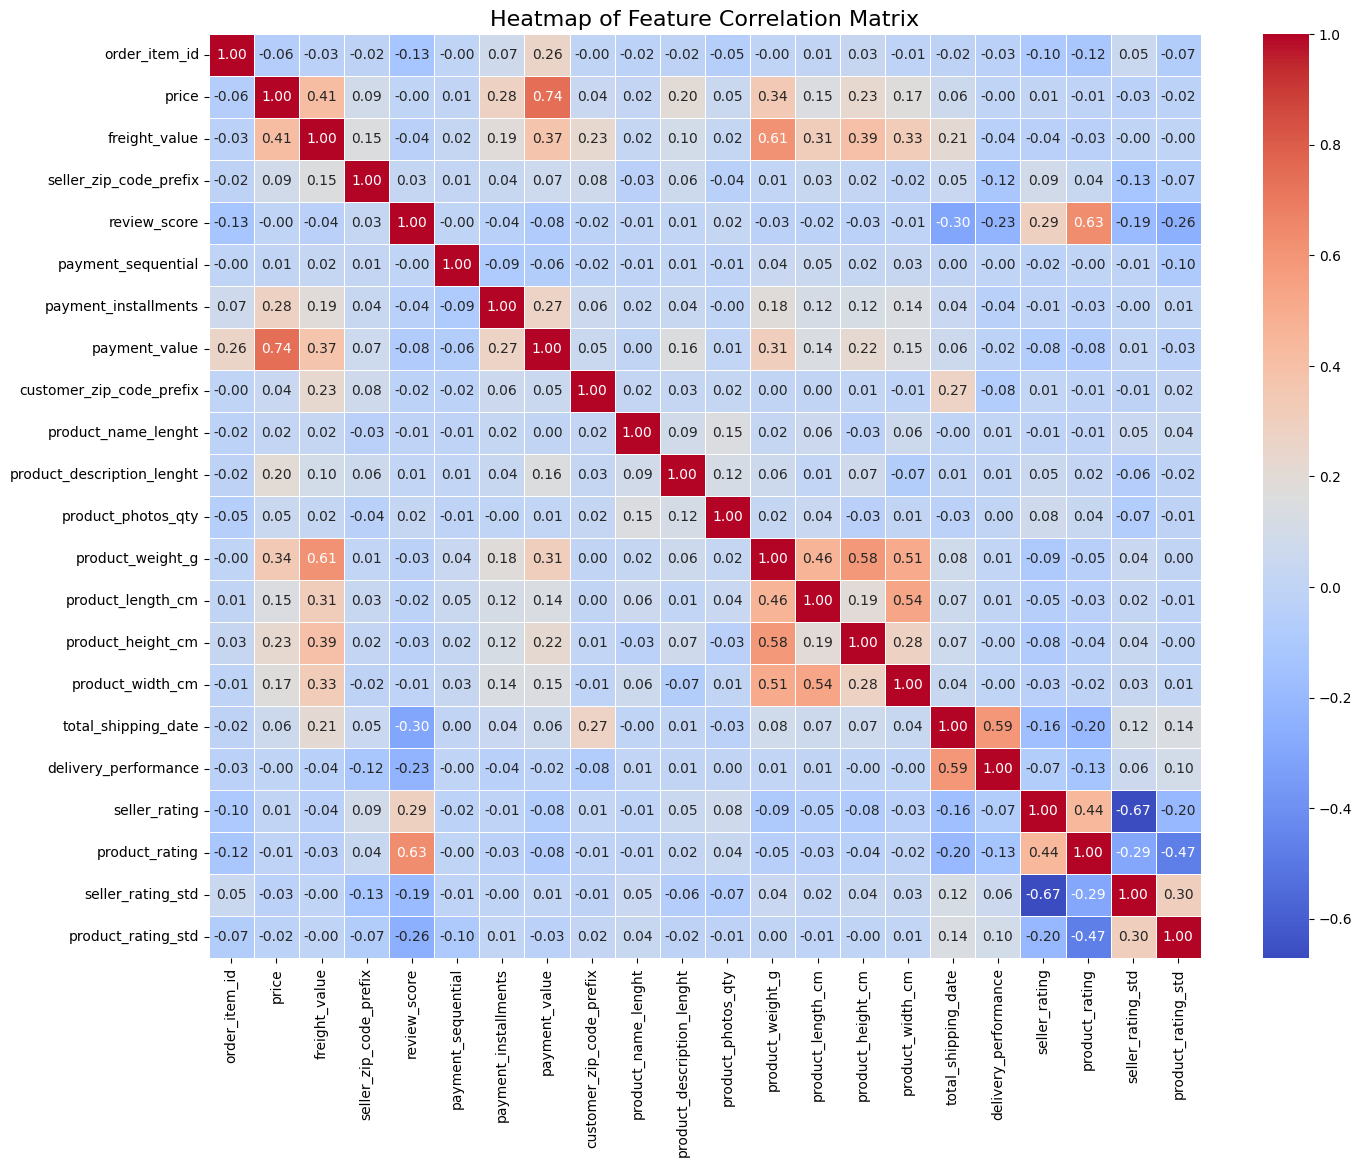

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan kolom tanggal memiliki tipe datetime
final_data['order_purchase_timestamp'] = pd.to_datetime(final_data['order_purchase_timestamp'], errors='coerce')
final_data['order_delivered_customer_date'] = pd.to_datetime(final_data['order_delivered_customer_date'], errors='coerce')
final_data['order_estimated_delivery_date'] = pd.to_datetime(final_data['order_estimated_delivery_date'], errors='coerce')

# Tambahkan kolom baru ke final_data
# Pastikan final_data adalah DataFrame utama Anda
final_data['total_shipping_date'] = (final_data['order_delivered_customer_date'] - final_data['order_purchase_timestamp']).dt.days
final_data['delivery_performance'] = (final_data['order_delivered_customer_date'] - final_data['order_estimated_delivery_date']).dt.days

# Hitung rata-rata review dan standar deviasi untuk seller dan product
seller_ratings = final_data.groupby('seller_id')['review_score'].mean()
product_ratings = final_data.groupby('product_id')['review_score'].mean()
seller_rating_std = final_data.groupby('seller_id')['review_score'].std()
product_rating_std = final_data.groupby('product_id')['review_score'].std()

# Tambahkan rating ke final_data
final_data = final_data.merge(seller_ratings.rename('seller_rating'), on='seller_id', how='left')
final_data = final_data.merge(product_ratings.rename('product_rating'), on='product_id', how='left')
final_data = final_data.merge(seller_rating_std.rename('seller_rating_std'), on='seller_id', how='left')
final_data = final_data.merge(product_rating_std.rename('product_rating_std'), on='product_id', how='left')

# Tampilkan semua kolom yang ada dalam final_data
print("Semua kolom dalam final_data:")
print(final_data.columns)

# Pilih hanya kolom numerik untuk heatmap
numeric_columns = final_data.select_dtypes(include=['float64', 'int64']).columns

# Hitung matriks korelasi
correlation_matrix = final_data[numeric_columns].corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)

# Tambahkan judul
plt.title("Heatmap of Feature Correlation Matrix", fontsize=16)

# Tampilkan heatmap
plt.show()


C:\Users\Raffi\AppData\Local\Temp\ipykernel_24736\3506260585.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_score_category', y='product_rating', data=final_data, palette="Set2")


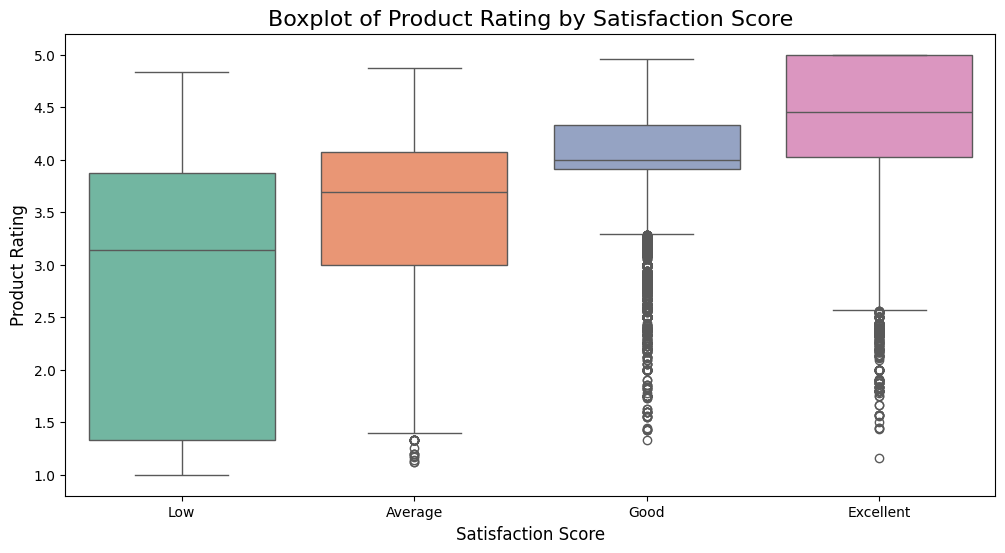

C:\Users\Raffi\AppData\Local\Temp\ipykernel_24736\3506260585.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_score_category', y='seller_rating', data=final_data, palette="Set2")


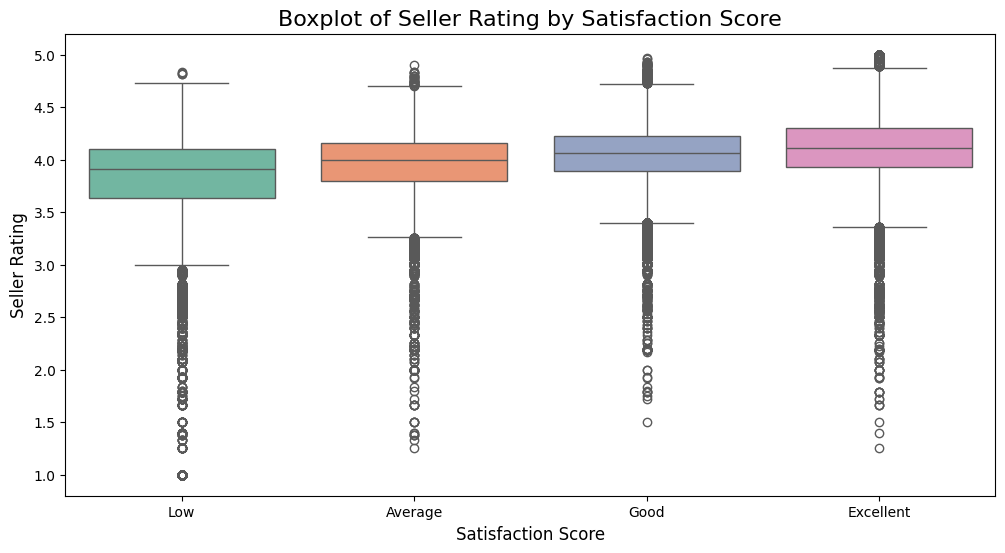

C:\Users\Raffi\AppData\Local\Temp\ipykernel_24736\3506260585.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_score_category', y='total_shipping_date', data=final_data, palette="Set2")


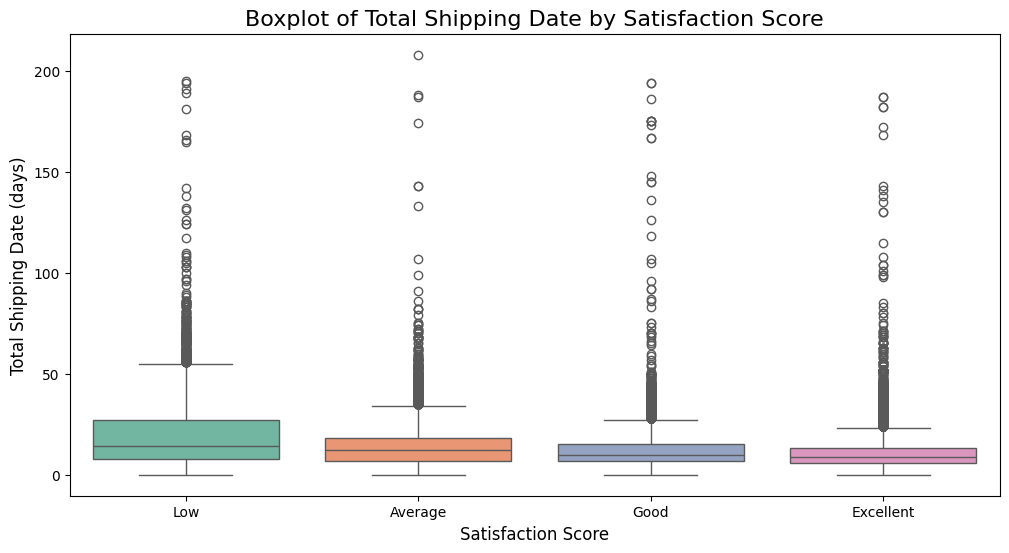

C:\Users\Raffi\AppData\Local\Temp\ipykernel_24736\3506260585.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_score_category', y='delivery_performance', data=final_data, palette="Set2")


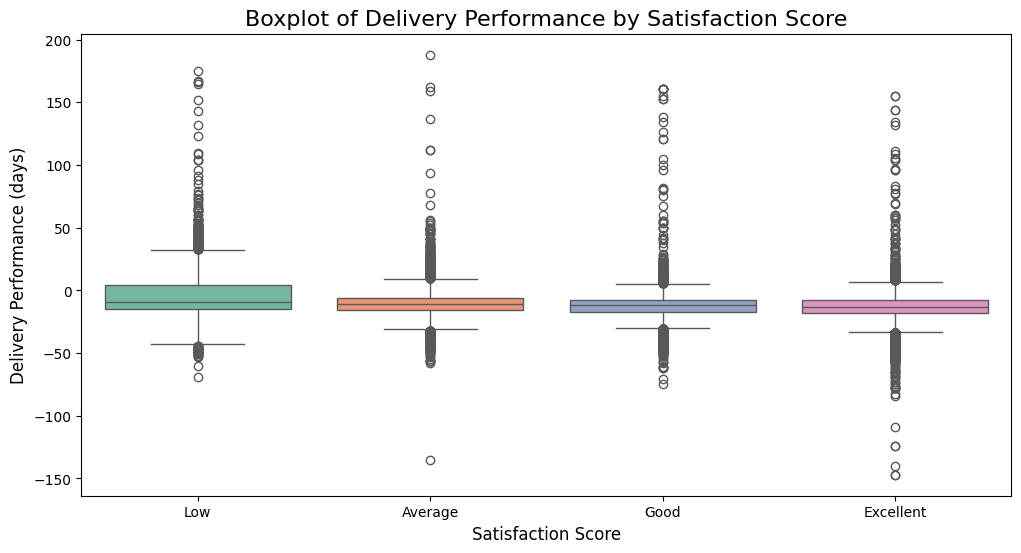

In [17]:
# Membuat kategori untuk review_score
def categorize_review_score(x):
    if x == 1:
        return 'Low'
    elif x == 2 or x == 3:
        return 'Average'
    elif x == 4:
        return 'Good'
    elif x == 5:
        return 'Excellent'

# Terapkan fungsi untuk membuat kolom baru 'review_score_category'
final_data['review_score_category'] = final_data['review_score'].apply(categorize_review_score)

# Urutkan kategori untuk review_score_category
final_data['review_score_category'] = pd.Categorical(final_data['review_score_category'], categories=['Low', 'Average', 'Good', 'Excellent'], ordered=True)

# Plot boxplot untuk product_rating berdasarkan review_score_category
plt.figure(figsize=(12, 6))
sns.boxplot(x='review_score_category', y='product_rating', data=final_data, palette="Set2")
plt.title('Boxplot of Product Rating by Satisfaction Score', fontsize=16)
plt.xlabel('Satisfaction Score', fontsize=12)
plt.ylabel('Product Rating', fontsize=12)
plt.show()

# Plot boxplot untuk seller_rating berdasarkan review_score_category
plt.figure(figsize=(12, 6))
sns.boxplot(x='review_score_category', y='seller_rating', data=final_data, palette="Set2")
plt.title('Boxplot of Seller Rating by Satisfaction Score', fontsize=16)
plt.xlabel('Satisfaction Score', fontsize=12)
plt.ylabel('Seller Rating', fontsize=12)
plt.show()

# Plot boxplot untuk total_shipping_date berdasarkan review_score_category
plt.figure(figsize=(12, 6))
sns.boxplot(x='review_score_category', y='total_shipping_date', data=final_data, palette="Set2")
plt.title('Boxplot of Total Shipping Date by Satisfaction Score', fontsize=16)
plt.xlabel('Satisfaction Score', fontsize=12)
plt.ylabel('Total Shipping Date (days)', fontsize=12)
plt.show()

# Plot boxplot untuk delivery_performance berdasarkan review_score_category
plt.figure(figsize=(12, 6))
sns.boxplot(x='review_score_category', y='delivery_performance', data=final_data, palette="Set2")
plt.title('Boxplot of Delivery Performance by Satisfaction Score', fontsize=16)
plt.xlabel('Satisfaction Score', fontsize=12)
plt.ylabel('Delivery Performance (days)', fontsize=12)
plt.show()

In [18]:
import pandas as pd
import numpy as np
from collections import Counter

# Fungsi untuk menghitung entropi
def entropy(data):
    total = len(data)
    counts = Counter(data)
    probabilities = [count / total for count in counts.values()]
    return -sum(p * np.log2(p) for p in probabilities)

# Fungsi untuk menghitung Gain Information
def gain_information(data, feature, target):
    # Entropi awal (untuk seluruh dataset)
    entropy_before = entropy(data[target])

    # Entropi setelah pemisahan berdasarkan feature
    feature_values = data[feature].unique()
    weighted_entropy_sum = 0

    for value in feature_values:
        subset = data[data[feature] == value]
        weighted_entropy_sum += (len(subset) / len(data)) * entropy(subset[target])

    # Gain Information
    return entropy_before - weighted_entropy_sum

# Contoh DataFrame yang sudah ada
# final_data = pd.DataFrame(...)

# Sampling data untuk mempercepat perhitungan (50% data secara acak)
sampled_data = final_data.sample(frac=0.5, random_state=42)  # Tetapkan random_state agar hasil dapat direproduksi

# Tentukan atribut dan target
target_column = 'review_score'  # Ganti dengan kolom target yang sesuai
features = ['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_id',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'total_shipping_date', 'delivery_performance', 'seller_rating',
       'product_rating', 'seller_rating_std', 'product_rating_std']

# Hitung Gain Information untuk setiap fitur
for feature in features:
    gain = gain_information(sampled_data, feature, target_column)
    print(f"Gain Information untuk {feature}: {gain}")

Gain Information untuk order_id: 1.7615729456057507
Gain Information untuk order_item_id: 0.01274138247802159
Gain Information untuk product_id: 0.8812992565687077
Gain Information untuk seller_id: 0.17774093448164763
Gain Information untuk shipping_limit_date: 1.7222508751395091
Gain Information untuk price: 0.21019460575502347
Gain Information untuk freight_value: 0.2891401303733574
Gain Information untuk seller_zip_code_prefix: 0.14063239505350644
Gain Information untuk seller_city: 0.045322894085304544
Gain Information untuk seller_state: 0.0026040586310538405
Gain Information untuk review_id: 1.7647873718046592
Gain Information untuk review_comment_title: 1.709642369468557
Gain Information untuk review_comment_message: 1.7290003138841747
Gain Information untuk review_creation_date: 0.06428037999642533
Gain Information untuk review_answer_timestamp: 1.7638911893023907
Gain Information untuk payment_sequential: 0.0012404227539017931
Gain Information untuk payment_type: 0.00046726974

Gain Information untuk order_id: 1.7615729456057507
Gain Information untuk order_item_id: 0.01274138247802159
Gain Information untuk product_id: 0.8812992565687077
Gain Information untuk seller_id: 0.17774093448164763
Gain Information untuk shipping_limit_date: 1.7222508751395091
Gain Information untuk price: 0.21019460575502347
Gain Information untuk freight_value: 0.2891401303733574
Gain Information untuk seller_zip_code_prefix: 0.14063239505350644
Gain Information untuk seller_city: 0.045322894085304544
Gain Information untuk seller_state: 0.0026040586310538405
Gain Information untuk review_id: 1.7647873718046592
Gain Information untuk review_comment_title: 1.709642369468557
Gain Information untuk review_comment_message: 1.7290003138841747
Gain Information untuk review_creation_date: 0.06428037999642533
Gain Information untuk review_answer_timestamp: 1.7638911893023907
Gain Information untuk payment_sequential: 0.0012404227539017931
Gain Information untuk payment_type: 0.00046726974

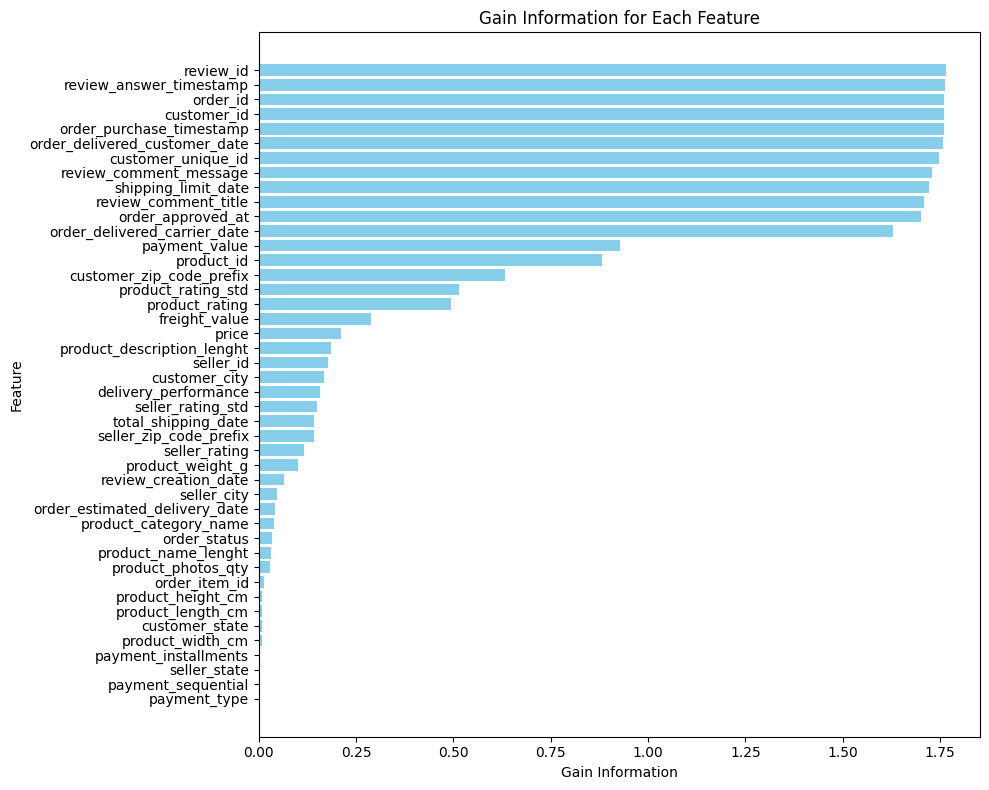

In [19]:
import matplotlib.pyplot as plt

# Dictionary untuk menyimpan hasil Gain Information
gain_info = {}

# Hitung Gain Information untuk setiap fitur dan simpan ke dictionary
for feature in features:
    gain = gain_information(sampled_data, feature, target_column)
    gain_info[feature] = gain
    print(f"Gain Information untuk {feature}: {gain}")

# Konversi dictionary ke DataFrame untuk mempermudah plotting
gain_df = pd.DataFrame(list(gain_info.items()), columns=['Feature', 'Gain Information'])
gain_df = gain_df.sort_values(by='Gain Information', ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 8))
plt.barh(gain_df['Feature'], gain_df['Gain Information'], color='skyblue')
plt.xlabel('Gain Information')
plt.ylabel('Feature')
plt.title('Gain Information for Each Feature')
plt.gca().invert_yaxis()  # Membalik sumbu y agar fitur dengan gain tertinggi berada di atas
plt.tight_layout()
plt.show()


In [20]:
gain_df = pd.DataFrame(list(gain_info.items()), columns=['Feature', 'Gain Information'])
# Hitung kuartil pertama (25%)
q1 = gain_df['Gain Information'].quantile(0.25)

# Pilih fitur dengan Gain Information >= kuartil pertama
selected_features = gain_df[gain_df['Gain Information'] >= q1]['Feature'].tolist()

# Tampilkan hasil
print("Fitur yang dipertahankan:")
print(selected_features)

print("\nFitur yang dihapus (Gain Information di bawah kuartil 25%):")
removed_features = gain_df[gain_df['Gain Information'] < q1]['Feature'].tolist()
print(removed_features)

# Dataset dengan fitur yang dipertahankan
filtered_data = sampled_data[selected_features + [target_column]]

Fitur yang dipertahankan:
['order_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'seller_zip_code_prefix', 'seller_city', 'review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'payment_value', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'product_category_name', 'product_description_lenght', 'product_weight_g', 'total_shipping_date', 'delivery_performance', 'seller_rating', 'product_rating', 'seller_rating_std', 'product_rating_std']

Fitur yang dihapus (Gain Information di bawah kuartil 25%):
['order_item_id', 'seller_state', 'payment_sequential', 'payment_type', 'payment_installments', 'customer_state', 'product_name_lenght', 'product_photos_qty', 'product_length_cm', 'product_height_cm', 'produ

In [23]:
# Gabungkan langkah 1 dan 2: Praproses dan Pembagian Data
def prepare_data(data, features, target, test_size=0.2, random_state=42):
    """
    Praproses data dan bagi menjadi training dan testing set.
    """
    # Ambil data yang lengkap (tanpa NaN)
    data = data.dropna(subset=features + [target])

    # Mapping untuk menggabungkan kelas 1 dan 2 menjadi kelas baru 1
    class_mapping = {0: 0, 1: 1, 2: 1, 3: 2, 4: 3}
    data[target] = data[target].map(class_mapping)

    # Pastikan tidak ada NaN setelah pemetaan
    data = data.dropna(subset=[target])

    # Normalisasi fitur
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])

    # Ubah menjadi array
    X = data[features].values
    y = data[target].values

    # Ubah bentuk data untuk LSTM (samples, timesteps, features)
    # Asumsikan setiap sample memiliki 1 timestep
    X = np.expand_dims(X, axis=1)

    # Bagi data menjadi training dan testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test


Epoch 1/100


C:\Users\Raffi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2298/2298 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7881 - loss: 0.6888 - val_accuracy: 0.8090 - val_loss: 0.5661
Epoch 2/100
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8069 - loss: 0.5736 - val_accuracy: 0.8102 - val_loss: 0.5616
Epoch 3/100
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8089 - loss: 0.5639 - val_accuracy: 0.8111 - val_loss: 0.5587
Epoch 4/100
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8097 - loss: 0.5645 - val_accuracy: 0.8138 - val_loss: 0.5549
Epoch 5/100
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8120 - loss: 0.5602 - val_accuracy: 0.8148 - val_loss: 0.5576
Epoch 6/100
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8147 - loss: 0.5563 - val_accuracy: 0.8133 - val_loss: 0.5540
Epoch 7/100
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8139 - loss: 0.5529 - val_accuracy: 0.8160 - val_loss: 0.5506
Epoch 8/100
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8138 - loss: 0.5540 - val_

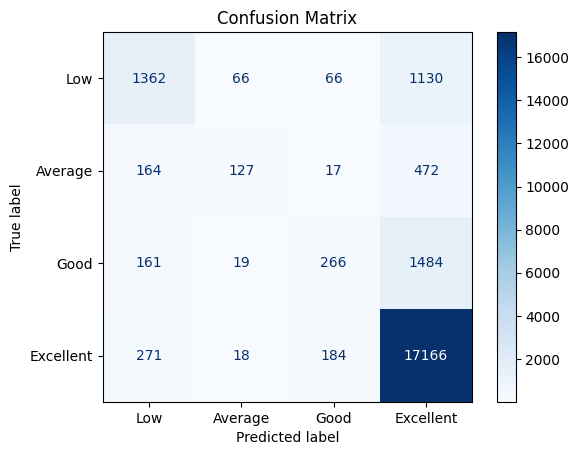

Classification Report:
              precision    recall  f1-score   support

         Low       0.70      0.52      0.59      2624
     Average       0.55      0.16      0.25       780
        Good       0.50      0.14      0.22      1930
   Excellent       0.85      0.97      0.91     17639

    accuracy                           0.82     22973
   macro avg       0.65      0.45      0.49     22973
weighted avg       0.79      0.82      0.79     22973



In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Gabungkan langkah 1 dan 2: Praproses dan Pembagian Data
def prepare_data(data, features, target, test_size=0.2, random_state=42):
    """
    Praproses data dan bagi menjadi training dan testing set.
    """
    # Ambil data yang lengkap (tanpa NaN)
    data = data.dropna(subset=features + [target])

    # Normalisasi fitur
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])

    # Ubah menjadi array
    X = data[features].values
    y = data[target].values

    # Jika target adalah kategori (klasifikasi), ubah menjadi integer
    y = y.astype(int) - 1  # Sesuaikan nilai label agar dimulai dari 0

    # Pastikan tidak ada label yang lebih besar dari 3
    y = np.clip(y, 0, 3)

    # Ubah bentuk data untuk LSTM (samples, timesteps, features)
    # Asumsikan setiap sample memiliki 1 timestep
    X = np.expand_dims(X, axis=1)

    # Bagi data menjadi training dan testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Nama kolom fitur dan target
features = ['product_rating', 'seller_rating', 'total_shipping_date', 'delivery_performance']  # Ganti dengan nama kolom fitur
target = 'review_score'

# Panggil fungsi prepare_data
X_train, X_test, y_train, y_test = prepare_data(final_data.copy(), features, target)

# Buat Model LSTM
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # Output untuk klasifikasi 4 kelas
])

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih Model dengan epoch = 100
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,  # Jumlah epoch
    batch_size=32,
    verbose=1
)

# Evaluasi Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Prediksi
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion Matrix dan Classification Report
class_names = ['Low', 'Average', 'Good', 'Excellent']  # Nama kelas baru
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(
    y_test, y_pred,
    target_names=class_names
)
print("Classification Report:")
print(report)


In [29]:
# Gabungkan langkah 1 dan 2: Praproses dan Pembagian Data
def prepare_data(data, features, target, test_size=0.2, random_state=42):
    """
    Praproses data dan bagi menjadi training dan testing set.
    """
    # Ambil data yang lengkap (tanpa NaN)
    data = data.dropna(subset=features + [target])

    # Normalisasi fitur
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])

    # Ubah menjadi array
    X = data[features].values
    y = data[target].values

    # Jika target adalah kategori (klasifikasi), ubah menjadi integer
    y = y.astype(int) - 1  # Sesuaikan nilai label agar dimulai dari 0

    # Pastikan tidak ada label yang lebih besar dari 3
    y = np.clip(y, 0, 3)

    # Memeriksa distribusi target setelah pemetaan
    print("Distribusi target setelah pemetaan:")
    print(pd.Series(y).value_counts())  # Memeriksa distribusi target yang telah dipetakan

    # Ubah bentuk data untuk LSTM (samples, timesteps, features)
    # Asumsikan setiap sample memiliki 1 timestep
    X = np.expand_dims(X, axis=1)

    # Bagi data menjadi training dan testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Nama kolom fitur dan target
features = ['product_rating', 'seller_rating', 'total_shipping_date', 'delivery_performance']  # Ganti dengan nama kolom fitur
target = 'review_score'

# Panggil fungsi prepare_data
X_train, X_test, y_train, y_test = prepare_data(final_data.copy(), features, target)


Distribusi target setelah pemetaan:
3    88191
0    13121
2     9650
1     3899
Name: count, dtype: int64


==============